In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn

Ethen 2017-01-03 21:32:42 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.3
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.18


Some of the materials builds on top of the [previous documentation/implementation on decision trees](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/decision_tree.ipynb), thus it might be best to walk through that one first.

# Ensemble Trees

Ensembling is a very popular method for improving the predictive performance of machine learning models. Let's pretend that instead of building a single model to solve a binary classification problem, you created **five independent models**, and each model was correct about 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

In [3]:
# generate 1000 random numbers (between 0 and 1) for each model, 
# representing 1000 observations
np.random.seed(1234)
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") 
# if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean()) 

0.713
0.665
0.717
0.712
0.687


In [4]:
# average the predictions, and then round to 0 or 1
# you can also do a weighted average, as long as the weight adds up to 1 
ensemble_preds = np.round( (preds1 + preds2 + preds3 + preds4 + preds5) / 5 ).astype(int)

# how accurate was the ensemble?
print(ensemble_preds.mean())

0.841


## Bagging

The primary weakness of decision trees is that they don't tend to have the best predictive accuracy and the result can be very unstable. This is partially due to the fact that we were using greedy algorithm to choose the rule/feature to split the tree. Hence a small variations in the data might result in a completely different tree being generated. Fortunately, this problem can be mitigated by training an ensemble of decision trees and use these trees to form a "forest".

This first idea we'll introduce is **Bagging**. **Bagging**, short for **bootstrap aggregation** is a general procedure for reducing the variance of a machine learning algorithm, although it can used with any type of method, it is most commonly applied to tree-based models. The way it works is: 

Given a training set $X = x_1, ..., x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($B$ times) selects a random sample with replacement (a.k.a bootstrap sample) of the training set and fits trees to these newly generated samples:

For $b = 1, ..., B$:
 
1. Sample, with replacement, $n$ training examples from $X$, $Y$; call these $X_b$, $Y_b$. Note that the bootstrap sample should be the same size as the original training set
2. Train a tree, $f_b$, on $X_b$, $Y_b$. For these individual tree, we should allow them to grow deeper (increase the max_depth paramter) so that they have low bias/high variance

After training, predictions for unseen samples $x'$ can be made by averaging the predictions from all the individual regression trees on $x'$:

$$ {\hat {f}}={\frac {1}{B}}\sum _{b=1}^{B}{\hat {f}}_{b}(x')$$

or by taking the majority vote in the case of classification trees.

## Random Forest

Random Forests is very similar to bagged trees. Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set. When building each tree, however, each time a split is considered, a random sample of $m$ features is chosen as split candidates from the full set of $p$ features. The split is only allowed to use one of those $m$ features to generate the best rule/feature to split on. 

- For **classification**, $m$ is typically chosen to be, $\sqrt{p}$, the square root of $p$
- For **regression**, $m$ is typically chosen to be somewhere between $p/3$ and $p$

The whole point of choosing a new random sample of features for every single tree at every single split is to correct for decision trees' habit of overfitting to their training set. Suppose there is one very strong feature in the data set, when using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are highly correlated. By randomly leaving out candidate features from each split, Random Forests "decorrelates" the trees, such that the averaging process can further reduce the variance of the resulting model.

## Implementation

Here, we will use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) to test our implementation. This [link](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv) should download the .csv file. The task is to predict the quality of the wine (a scale of 1 ~ 10) given some of its features. We'll build three types of regression model, decision tree, bagged decision tree and random forest on the training set and compare the result on the test set.

In [5]:
wine = pd.read_csv('winequality-white.csv', sep = ';')

# train/test split the features and response column
y = wine['quality'].values
X = wine.drop('quality', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

print('dimension of the dataset: ', wine.shape)
wine.head()

dimension of the dataset:  (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
# this cell simply demonstrates how to create boostrap samples
# we create an array of numbers from 1 to 20
# create the boostrap sample on top of that
np.random.seed(1)
nums = np.arange(1, 21)
print( 'original:', nums)
print( 'bootstrap: ', np.random.choice(nums, size = 20, replace = True) )

original: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
bootstrap:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


In [7]:
class RandomForest:
    """
    regression random forest using scikit learn's 
    decision tree as the base tree
    
    Parameters
    ----------
    n_estimators: int 
        the number of trees that you're going built
        on the bagged sample (you can even shutoff
        the bagging procedure for some packages)
    
    max_features: int 
        the number of features that you allow
        when deciding which feature to split on 
    
    all the other parameters for a decision tree like
    max_depth or min_sample_split also applies to Random Forest, 
    it is just not used here as that is more
    related to a single decision tree
    """    
    def __init__(self, n_estimators, max_features):
        self.n_estimators = n_estimators
        self.max_features = max_features
        
    def fit(self, X, y):
        # for each base-tree models:
        # 1. draw bootstrap samples from the original data
        # 2. train the tree model on that bootstrap sample, and
        #    during training, randomly select a number of features to 
        #    split on each node
        self.estimators = []
        for i in range(self.n_estimators):
            boot = np.random.choice(y.shape[0], size = y.shape[0], replace = True)
            X_boot, y_boot = X[boot], y[boot]
            tree = DecisionTreeRegressor(max_features = self.max_features)
            tree.fit(X_boot, y_boot)
            self.estimators.append(tree)
            
        return self

    def predict(self, X):
        # for the prediction, we simply average the
        # predictions made by each of the bagged tree
        pred = np.empty((X.shape[0], self.n_estimators))
        for i, tree in enumerate(self.estimators):
            pred[:, i] = tree.predict(X)
            
        pred = np.mean(pred, axis = 1)
        return pred

In [8]:
# compare the results between a single decision tree,
# bagging and random forest, the lower the mean square
# error, the better
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
tree_y_pred = tree.predict(X_test)
print( 'tree: ', mean_squared_error(y_test, tree_y_pred) )

# bagged decision tree
# max_feature = None simply uses all features
bag = RandomForest(n_estimators = 50, max_features = None)
bag.fit(X_train, y_train)
bag_y_pred = bag.predict(X_test)
print( 'bagged tree: ', mean_squared_error(y_test, bag_y_pred) )

# random forest using a random one third of the features at every split
rf = RandomForest(n_estimators = 50, max_features = 1 / 3)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
print( 'random forest: ',  mean_squared_error(y_test, rf_y_pred) )

# use library to confirm results are comparable
rf_reg = RandomForestRegressor(n_estimators = 50, max_features = 1 / 3)
rf_reg.fit(X_train, y_train)
rf_reg_y_pred = rf_reg.predict(X_test)
print( 'random forest library: ', mean_squared_error(y_test, rf_reg_y_pred) )

tree:  0.790816326531
bagged tree:  0.404054693878
random forest:  0.390586530612
random forest library:  0.398487755102


## Feature Importance

When using Bagging with decision tree or using Random Forest, we can increase the predictive accuracy of individual tree. These methods, however, do decrease model interpretability, because it is no longer possible to visualize all the trees that are built to form the "forest". Fortunately, we can still obtain an overall summary of feature importance from these models. The way feature importance works is as follows (there are many ways to do it, this is the implementation that scikit-learn uses):

We first compute the feature importance values of a single tree:

- We can initialize an array `feature_importances` of all zeros with size `n_features`
- We start building the tree and for each internal node that splits on feature $i$ we compute the information gain (error reduction) of that node multiplied by the proportion of samples that were routed to the node and add this quantity to `feature_importances[i]`

The information gain (error reduction) depends on the impurity criterion that you use (e.g. Gini, Entropy for classification, MSE for regression). Its the impurity of the set of examples that gets routed to the internal node minus the sum of the impurities of the two partitions created by the split.

Now, recall that these Ensemble Tree models simply consists of a bunch of individual trees. So we simply sum up the `feature_importance` values across all individual trees and take the average across all of them (normalize it to sum up to 1 if necessary). 

Building on top of the [previous documentation/implementation on decision trees](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/decision_tree.ipynb), we add the code to compute the feature importance. The code is not shown here to prevent cluttering the page, but it can be obtained [here](https://github.com/ethen8181/machine-learning/blob/master/trees/tree.py) for those that are interested.

In [11]:
from tree import Tree

# load a sample dataset
iris = load_iris()
iris_X = iris.data
iris_y = iris.target

# train model and print the feature importance
tree = Tree()
tree.fit(iris_X, iris_y)
print(tree.feature_importance)

# use library to confirm result
# note that the result might not always be the same
# because of decision tree's high variability
clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10, max_depth = 3)
clf.fit(iris_X, iris_y)
print(clf.feature_importances_)

[ 0.          0.          0.07060267  0.92939733]
[ 0.          0.          0.07060267  0.92939733]


For ensemble tree, we simply sum all the feauture importance up and take the average (normalize it to sum up to 1 if necessary). Thus, we will not go through the process of building that from scratch, we'll simply visualize the feature importance of the regression Random Forest that we've previously trained on the wine dataset.

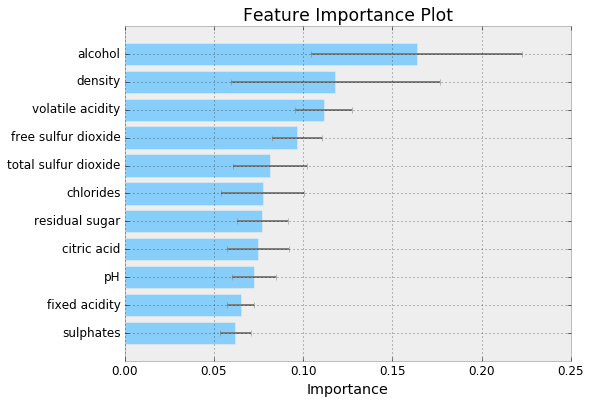

In [12]:
def viz_importance(model, feature_names, n_features):
    """Visualize the relative importance of predictors"""
    
    # apart from the mean feature importance, for scikit-learn we can access
    # each individual tree's feature importance and compute the standard deviation
    importances = model.feature_importances_
    importances_std = np.std([ tree.feature_importances_ for tree in model.estimators_ ], 
                             axis = 0)
    
    # sort the importance in decreasing order
    idx = np.argsort(importances)[-n_features:]
    names = feature_names[idx]
    scores = importances[idx]
    scores_std = importances_std[idx]
    
    y_pos = np.arange(1, n_features + 1)
    plt.barh(y_pos, scores, color = 'lightskyblue', align = 'center', 
             xerr = scores_std, ecolor = 'grey')
    plt.yticks(y_pos, names)
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')
    
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# visualize the feature importance of every variable
viz_importance(rf_reg, wine.columns[:-1], X.shape[1])

**Caveat:**

One thing to keep in mind when using the impurity based feature importance ranking is that when the dataset has two (or more) correlated features, then from the model's point of view, any of these correlated features can be used as the predictor, with no preference of one over the others. But once one of them is used, the importance of others is significantly reduced since the impurity they can effectively remove has already been removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when we're interpreting the data, it can lead to incorrect conclusions that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

The effect of this phenomenon for Random Forest is somewhat reduced thanks to random selection of features at each node creation, but in general the effect is not removed completely. In the following example, we have three correlated variables $X_0$, $X_1$, $X_2$, and no noise in the data, with the output variable simply being the sum of the three features:

In [13]:
size = 10000
np.random.seed(10)
X_seed = np.random.normal(0, 1, size)
X0 = X_seed + np.random.normal(0, 0.1, size)
X1 = X_seed + np.random.normal(0, 0.1, size)
X2 = X_seed + np.random.normal(0, 0.1, size)
X_012 = np.array([ X0, X1, X2 ]).T
Y = X0 + X1 + X2

rf = RandomForestRegressor(n_estimators = 20, max_features = 2)
rf.fit(X_012, Y)
print( 'Scores for X0, X1, X2:', np.round(rf.feature_importances_, 3) )

Scores for X0, X1, X2: [ 0.272  0.542  0.186]


When we compute the feature importances, we see that some of the features have higher importance than the others, while their “true” importance should be very similar. One thing to point out though is that the difficulty of interpreting the importance/ranking of correlated variables is not Random Forest specific, but applies to most model based feature selection methods. This is why it often best practice to remove correlated features prior to training the model.

**Advantages of Random Forests:**

- Performance and computation wise, it is very competitive. Although you can typically find a model that beats Random Forest for any given dataset (typically a deep learning or gradient boosting algorithm), it’s never by much, and it usually takes much longer to train and tune those model
- Require very little feature engineering (e.g. standardization)
- Easy to use, as it rarely requires parameter tuning to achieve compelling and robust performance
- Provides a more reliable estimate of feature importance compare to other black-box methods (e.g. deep learning, support vector machine)

## Extra Trees

What distinguishes Extra Trees from Random Forest is:

- We use the entire training set instead of a bootstrap sample of the training set.
- Just like Random Forest, when choosing rules/features at a split, a random subset of candidate features is used, but now, instead of looking at all the thresholds to find the best the best split, thresholds (for the split) are chosen completely at random for each candidate feature and the best of these randomly generated thresholds is picked as the splitting rule.

> Based on [Stackoverflow: RandomForestClassifier vs ExtraTreesClassifier in scikit learn](http://stackoverflow.com/questions/22409855/randomforestclassifier-vs-extratreesclassifier-in-scikit-learn?rq=1)
> In practice, RFs are often more compact than ETs. ETs are generally cheaper to train from a computational point of view but can grow much bigger. ETs can sometime generalize better than RFs but it's hard to guess when it's the case without trying both first (and tuning n_estimators, max_features and min_samples_split by cross-validated grid search).

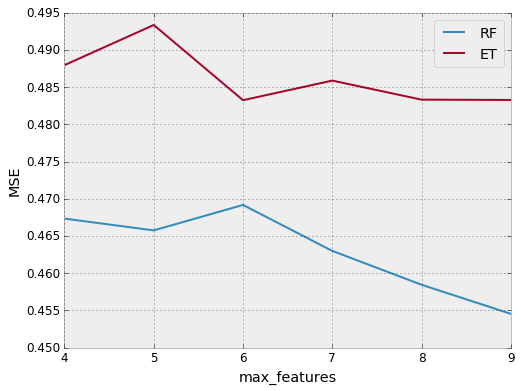

In [14]:
# grid search on a range of max features and compare 
# the performance between Extra Trees and Random Forest
param_name = 'max_features'
max_features_opt = np.arange(4, 10)
fit_param = {
    param_name : max_features_opt
}

rf_reg = RandomForestRegressor(n_estimators = 30)
et_reg = ExtraTreesRegressor(n_estimators = 30)
rs_rf = GridSearchCV(rf_reg, fit_param, n_jobs = -1)
rs_et = GridSearchCV(et_reg, fit_param, n_jobs = -1)
rs_rf.fit(X_train, y_train)
rs_et.fit(X_train, y_train)

# visualize the performance on the cross validation test score
rs_rf_mean_score = rs_rf.cv_results_['mean_test_score']
rs_et_mean_score = rs_et.cv_results_['mean_test_score']
mean_scores = [rs_rf_mean_score, rs_et_mean_score]
labels = ['RF', 'ET']

for score, label in zip(mean_scores, labels):
    plt.plot(max_features_opt, score, label = label)

plt.legend()
plt.ylabel('MSE')
plt.xlabel(param_name)
plt.xlim( np.min(max_features_opt), np.max(max_features_opt) )
plt.show()

It is not always the case that Random Forest will outperform Extra Trees and it's might be a method that's worth trying. As for interpretation, Extra Trees is simply another kind of Ensemble Tree method, hence we can still obtain access the `feature_importance` attribute to see which predictors were contributing a lot at explaining the response.

## Reference

- [Notebook: Ensembling](http://nbviewer.jupyter.org/github/justmarkham/DAT8/blob/master/notebooks/18_ensembling.ipynb)
- [Notebook: useR machine learning tutorial Random Forest](http://nbviewer.jupyter.org/github/ledell/useR-machine-learning-tutorial/blob/master/random-forest.ipynb)
- [Blog: Selecting good features – Part III: random forests](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
- [Blog: The Unreasonable Effectiveness of Random Forests](https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883#.pv7i5ien9)
- [Stackoverflow: RandomForestClassifier vs ExtraTreesClassifier in scikit learn](http://stackoverflow.com/questions/22409855/randomforestclassifier-vs-extratreesclassifier-in-scikit-learn?rq=1)
- [Stackoverflow: How are feature_importances in RandomForestClassifier determined?](http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)